In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/

## 1.
Generating N points on $[0,1]^2$ grid

In [ ]:
N = 25
points = np.random.random((N,2))

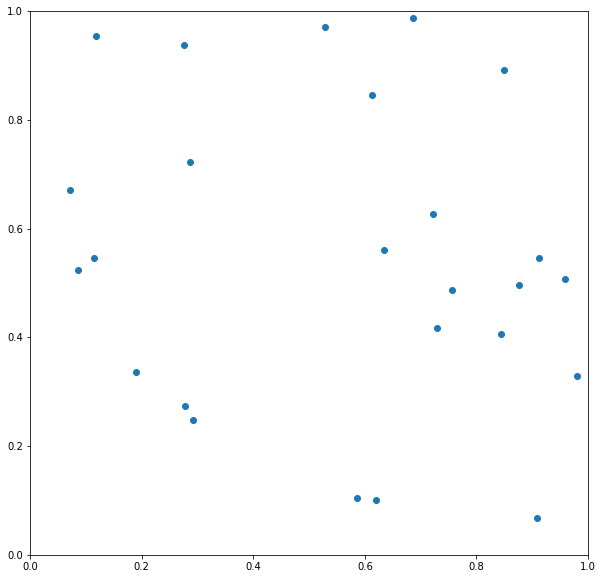

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(points[:,0], points[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 2.
Creating Voronoi polygons using points generated above.

In [ ]:
vor = Voronoi(points)

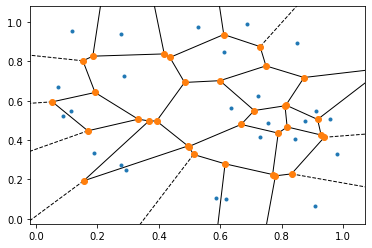

In [ ]:
f = voronoi_plot_2d(vor)
plt.show()

```
vor.points - punkty wejściowe
vor.vertices - wierzchołki obszarów
    remark: niektóre wierzchołki leżą poza tym obszarem [0,1]^2, no bo część obszarów za niego wychodzi
vor.regions - dla każdego regionu podane są indeksy wierzchołków, które tworzą ten region. -1 oznacza brak wierzchołka (byłby tak wywalony w kosmos, że jest pomijany chyba)
vor.point_region - dla każdego punktu podany jest jaki region początkowy mu odpowiada
```

## 3.
Replacing each point by the centroid of the region related to this point. Each region is convex, so the centroid is always inside the region.
We're skipping regions on the edge of the grid. It's hard to compute centroid for them, we don't know about the vertices outside the grid.

In [ ]:
centroids = np.zeros((N,2))
for i,p in enumerate(vor.point_region):
    region_vertices = [k for k in vor.regions[p] if k> -1]
    region_vertices_coords = vor.vertices[region_vertices]
    if np.any(region_vertices_coords > 1) or np.any(region_vertices_coords < 0):
        centroids[i:] = vor.points[i]
        continue
    centroid = region_vertices_coords.mean(axis=0)
    centroids[i,:] = centroid

<Figure size 720x720 with 0 Axes>

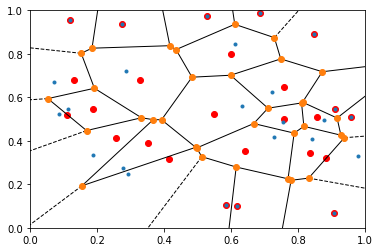

In [ ]:
plt.figure(figsize=(10,10))
f = voronoi_plot_2d(vor)
plt.scatter(centroids[:,0], centroids[:,1],c='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 4. 
Re-generating Voronoi regions using new points (centroids)

In [ ]:
vor2 = Voronoi(centroids)

<Figure size 720x720 with 0 Axes>

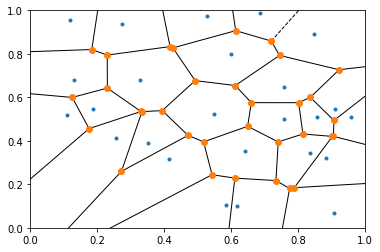

In [ ]:
plt.figure(figsize=(10,10))
f = voronoi_plot_2d(vor2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 5.
Converting infitite vertices to finite ones, then replacing vertices outside $[0,1]^2$ region by the intersection points.

In [ ]:
# source: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [ ]:
points = np.random.random((20,2))
vor = Voronoi(points)

In [ ]:
regions, vertices = voronoi_finite_polygons_2d(vor)

In [ ]:
new_regions = []
new_vertices = list(vertices.copy())

box = Polygon([[0, 0], [0, 1], [1, 1], [1, 0]])

for region in regions:
    poly = Polygon(vertices[region])
    poly = poly.intersection(box)
    region_elements = []
    for x,y in poly.exterior.coords[:-1]:
        p = np.array([x,y])
        for i,v in enumerate(new_vertices):
            if np.sum((v-p)**2) <= 1e-5:
                region_elements.append(i)
                break
        else:
            region_elements.append(len(new_vertices))
            new_vertices.append(p)
    new_regions.append(region_elements)

new_vertices = np.array(new_vertices)

In [ ]:
centroids = np.array([new_vertices[region].mean(axis=0) for region in new_regions])

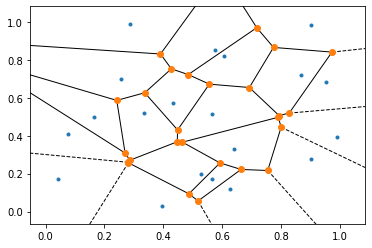

In [ ]:
voronoi_plot_2d(vor)
plt.show()

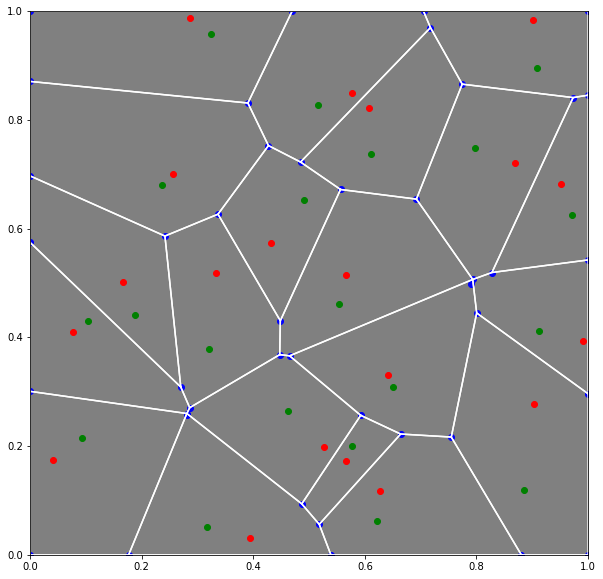

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.facecolor'] = 'grey'
for region in new_regions:
    region.append(region[0])
    coords = new_vertices[region]
    plt.plot(coords[:,0], coords[:,1],c='white')
plt.scatter(points[:,0], points[:,1], c='red')
plt.scatter(new_vertices[:,0], new_vertices[:,1], c='blue')
plt.scatter(centroids[:,0], centroids[:,1], c='green')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

Nie możemy użyć sąsiedztwa, które zwraca nam ta biblioteka, bo po sprowadzeniu tego do zamkniętego kwadratu to się psuje

In [ ]:
neighbors = [[] for i in range(len(new_regions))]
intersecions = [[] for i in range(len(new_regions))]
for i,region1 in enumerate(new_regions):
    for j,region2 in enumerate(new_regions):
        if i==j:
            continue
        poly1 = Polygon(new_vertices[region1])
        poly2 = Polygon(new_vertices[region2])
        
        if poly1.intersects(poly2):
            neighbors[i].append(j)
            intersection = np.array(poly1.intersection(poly2).coords)
            intersecions[i].append(intersection)

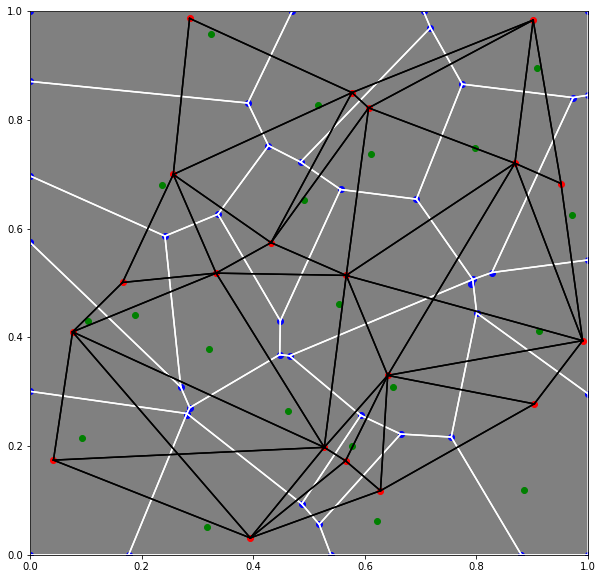

In [ ]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.facecolor'] = 'grey'
for region in new_regions:
    region.append(region[0])
    coords = new_vertices[region]
    plt.plot(coords[:,0], coords[:,1],c='white')
for i,n_list in enumerate(neighbors):
    p1 = points[i]
    for i2 in n_list:
        p2 = points[i2]
        plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='black')
plt.scatter(points[:,0], points[:,1], c='red')
plt.scatter(new_vertices[:,0], new_vertices[:,1], c='blue')
plt.scatter(centroids[:,0], centroids[:,1], c='green')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [ ]:
def generate_Voronoi(N=25, iterations=2):

    """
    params:
        N - number of points
        iterations - number of iterations for relaxation process
    returns:
        points - list of final points
        centroids - list of centroids of the regions
        vertices - list of vertices
        regions - indexes of vertices creating each region
        neighbors - indexes of neighbors regions for each region
        intersecions - lines separating each two neighbors
    """

    # generating the points
    points = np.random.random((N,2))

    for iter in range(iterations+1):

        # generating Voronoi regions
        vor = Voronoi(points)

        # transforming the regions to finite ones
        regions, vertices = voronoi_finite_polygons_2d(vor)

        # reducing the regions to [0,1]^2 space
        new_regions = []
        new_vertices = list(vertices.copy())

        box = Polygon([[0, 0], [0, 1], [1, 1], [1, 0]])

        for region in regions:
            poly = Polygon(vertices[region])
            poly = poly.intersection(box)
            region_elements = []
            for x,y in poly.exterior.coords[:-1]:
                p = np.array([x,y])
                for i,v in enumerate(new_vertices):
                    if np.sum((v-p)**2) <= 1e-5:
                        region_elements.append(i)
                        break
                else:
                    region_elements.append(len(new_vertices))
                    new_vertices.append(p)
            new_regions.append(region_elements)

        new_vertices = np.array(new_vertices)
        points = np.array([new_vertices[region].mean(axis=0) for region in new_regions])


    neighbors = [[] for i in range(len(new_regions))]
    intersecions = [[] for i in range(len(new_regions))]
    for i,region1 in enumerate(new_regions):
        for j,region2 in enumerate(new_regions):
            if i==j:
                continue
            poly1 = Polygon(new_vertices[region1])
            poly2 = Polygon(new_vertices[region2])
            
            if poly1.intersects(poly2):
                neighbors[i].append(j)
                intersection = np.array(poly1.intersection(poly2).coords)
                v1 = ((new_vertices - intersection[0])**2).sum(axis=1).argmin()
                v2 = ((new_vertices - intersection[1])**2).sum(axis=1).argmin()
                intersecions[i].append([v1,v2])

    return vor.points, points, new_vertices, new_regions, neighbors, intersecions

In [ ]:
def plot_Voronoi_grid(points, vertices, regions, neighbors, centroids=None):
    plt.figure(figsize=(10,10))
    plt.rcParams['axes.facecolor'] = 'grey'
    for region in regions:
        region.append(region[0])
        coords = vertices[region]
        plt.plot(coords[:,0], coords[:,1],c='white')
    for i,n_list in enumerate(neighbors):
        p1 = points[i]
        for i2 in n_list:
            p2 = points[i2]
            plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='black')
    plt.scatter(points[:,0], points[:,1], c='red')
    plt.scatter(vertices[:,0], vertices[:,1], c='blue')
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c='green')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

In [ ]:
points, centroids, vertices, regions, neighbors, intersecions = generate_Voronoi()

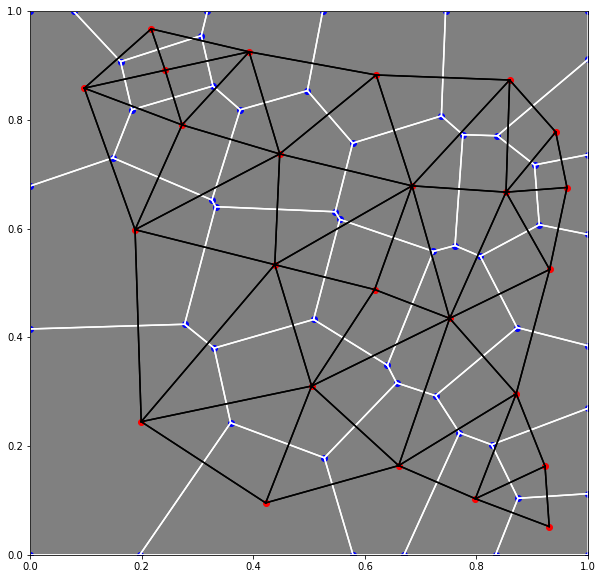

In [ ]:
plot_Voronoi_grid(points, vertices, regions, neighbors)

In [ ]:
points, centroids, vertices, regions, neighbors, intersecions = generate_Voronoi(100,2)

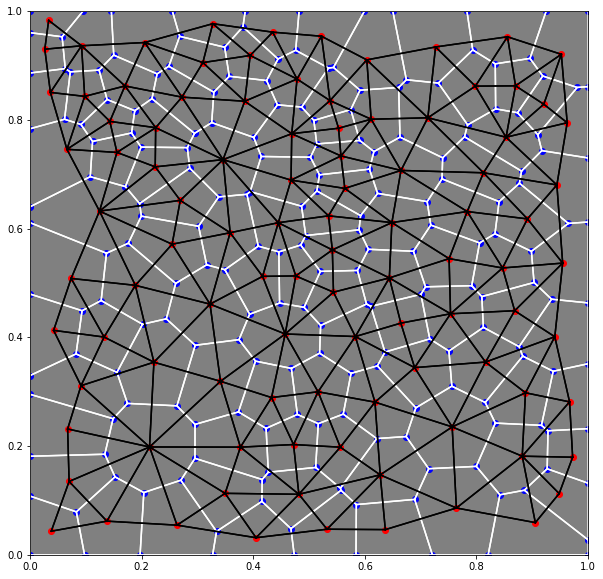

In [ ]:
plot_Voronoi_grid(points, vertices, regions, neighbors)

## 7. Map Representation
TODO

Chyba już rozumiem zamysł tego, on ma 3 klasy:

* punkty (te w środku, czerwone), nazywane środkami
* wierzchołki
* krawędzie

I jest taka zależność, że jeśli 2 obszary graniczą ze sobą, to mają dokładnie 1 linię wspólną. Więc krawędź łączy ze sobą 2 graniczące środki ORAZ 2 wierzchołki, które tworzą granicę pomiędzy tymi polami.

To daje więcej możliwości poruszania po tym grafie, do tego on ma następujące metody:

* Center.neighbors is a set of adjacent polygons
* Center.borders is a set of bordering edges
* Center.corners is a set of polygon corners
* Edge.d0 and Edge.d1 are the polygons connected by the Delaunay edge
* Edge.v0 and Edge.v1 are the corners connected by the Voronoi edge
* Corner.touches is a set of polygons touching this corner
* Corner.protrudes is a set of edges touching the corner
* Corner.adjacent is a set of corners connected to this one

In [ ]:
class Center:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.neighbors = []
        self.borders = []
        self.corners = []

In [ ]:
class Corner:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.touches = []
        self.protrudes = []
        self.adjacent = []

In [ ]:
class Edge:

    def __init__(self, center1, center2, corner1, corner2):
        self.d0 = center1
        self.d1 = center2
        self.v0 = corner1
        self.v1 = corner2

In [ ]:
points, centroids, vertices, regions, neighbors, intersecions = generate_Voronoi()

In [ ]:
def initialize_graph(points, vertices, regions, neighbors, intersecions):

    # creating center object for each point
    centers = []
    for p in points:
        center = Center(p[0], p[1])
        centers.append(center)

    # creating corner object for each vertex
    corners = []
    for v in vertices:
        corner = Corner(v[0], v[1])
        corners.append(corner)

    # setting neighbors and corners lists for each center
    for i,c in enumerate(center):
        c.neighbors = [centers[k] for k in neighbors[i]]
        c.corners = [corners[k] for k in regions[i]]

    for i,corners_list in regions:
        for cor in corners_list:
            corners[cor].touches.append(i)

    edges = {}
    for c1, neighbours_list in enumerate(neighbors):
        for i,c2 in enumerate(neighbours_list):
            if (c1,c2) in edges:
                continue
            
            cor1, cor2 = intersecions[c1][i]
            edge = Edge(centers[c1], centers[c2], corners[cor1], corners[cor2])
            centers[c1].borders.append(edge)
            centers[c2].borders.append(edge)
            corners[cor1].protrudes.append(edge)
            corners[cor2].protrudes.append(edge)
            corners[cor1].adjacent.append(cor2)
            corners[cor2].adjacent.append(cor1)

            edges[(c1,c2)] = edge
    
    return centers, corners, edges

In [ ]:
# TODO nie wiem czy to wyżej działa, pewnie nie